# AIT 664 – Project: Garment Worker Productivity Analysis



### Step-by-Step Implementation

### Step 1: Import Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier, VotingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, make_scorer,  roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import joblib
from scipy.stats import f_oneway

### Step 2: Load and Clean Dataset

In [6]:
# Load dataset and clean column names
df = pd.read_csv("D:/ABHIRAM/Documents/OneDrive/Desktop/AIT 664/garments_worker_productivity.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.dropna(inplace=True)

### Step 3: Feature Engineering

In [8]:
# Parse dates and extract components
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
# Drop unnecessary columns
df.drop(columns=['date', 'quarter', 'department'], inplace=True, errors='ignore')
# Created binary classification target for inefficiency
df['inefficient'] = df['actual_productivity'] < df['actual_productivity'].mean()

### Step 4: Exploratory Data Analysis

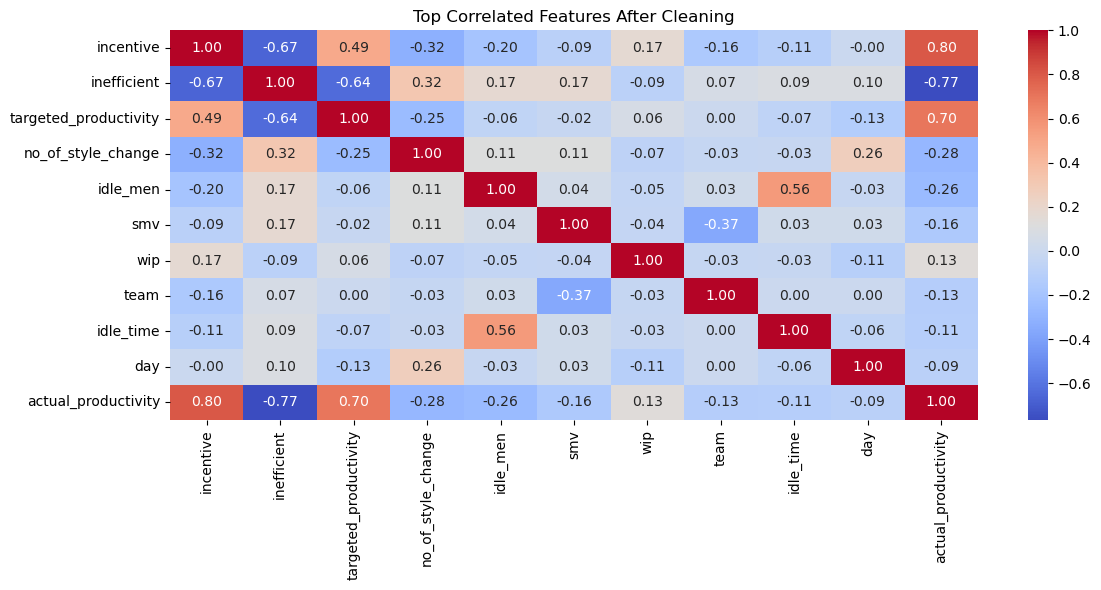

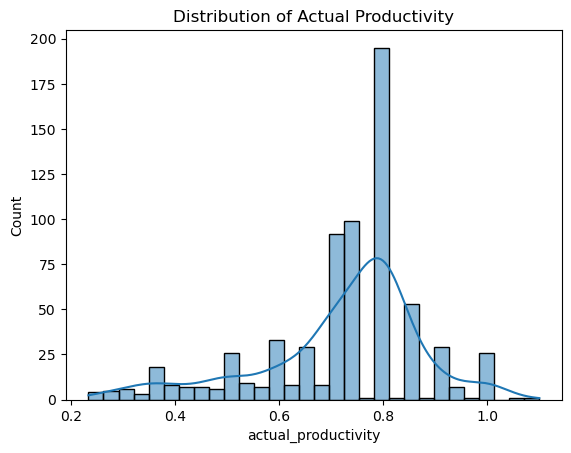

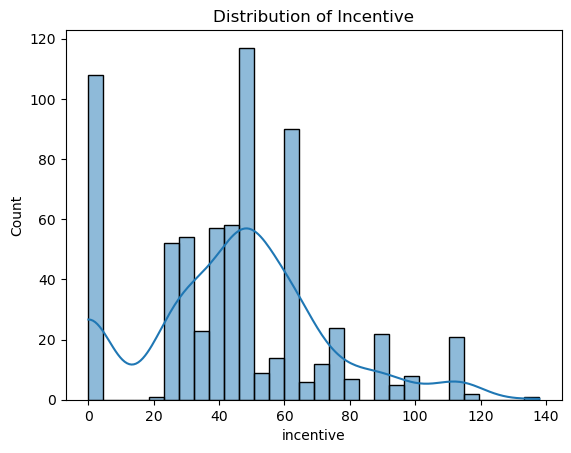

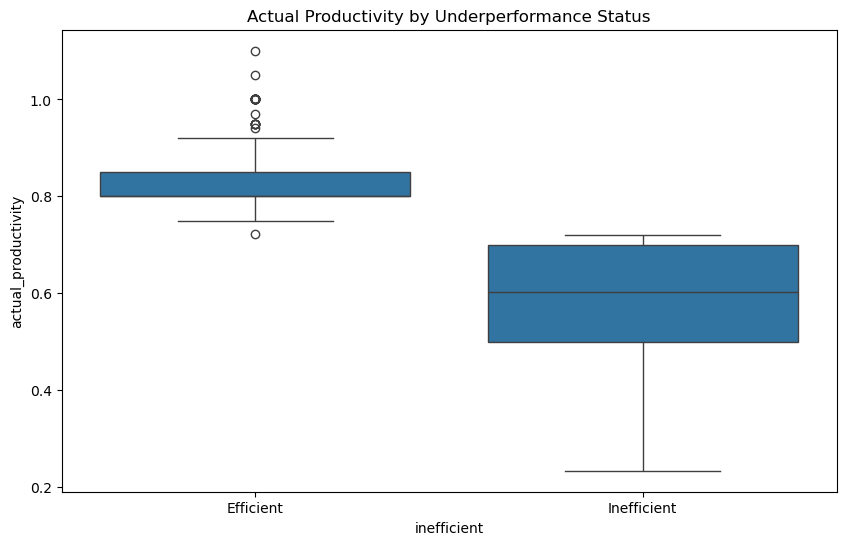

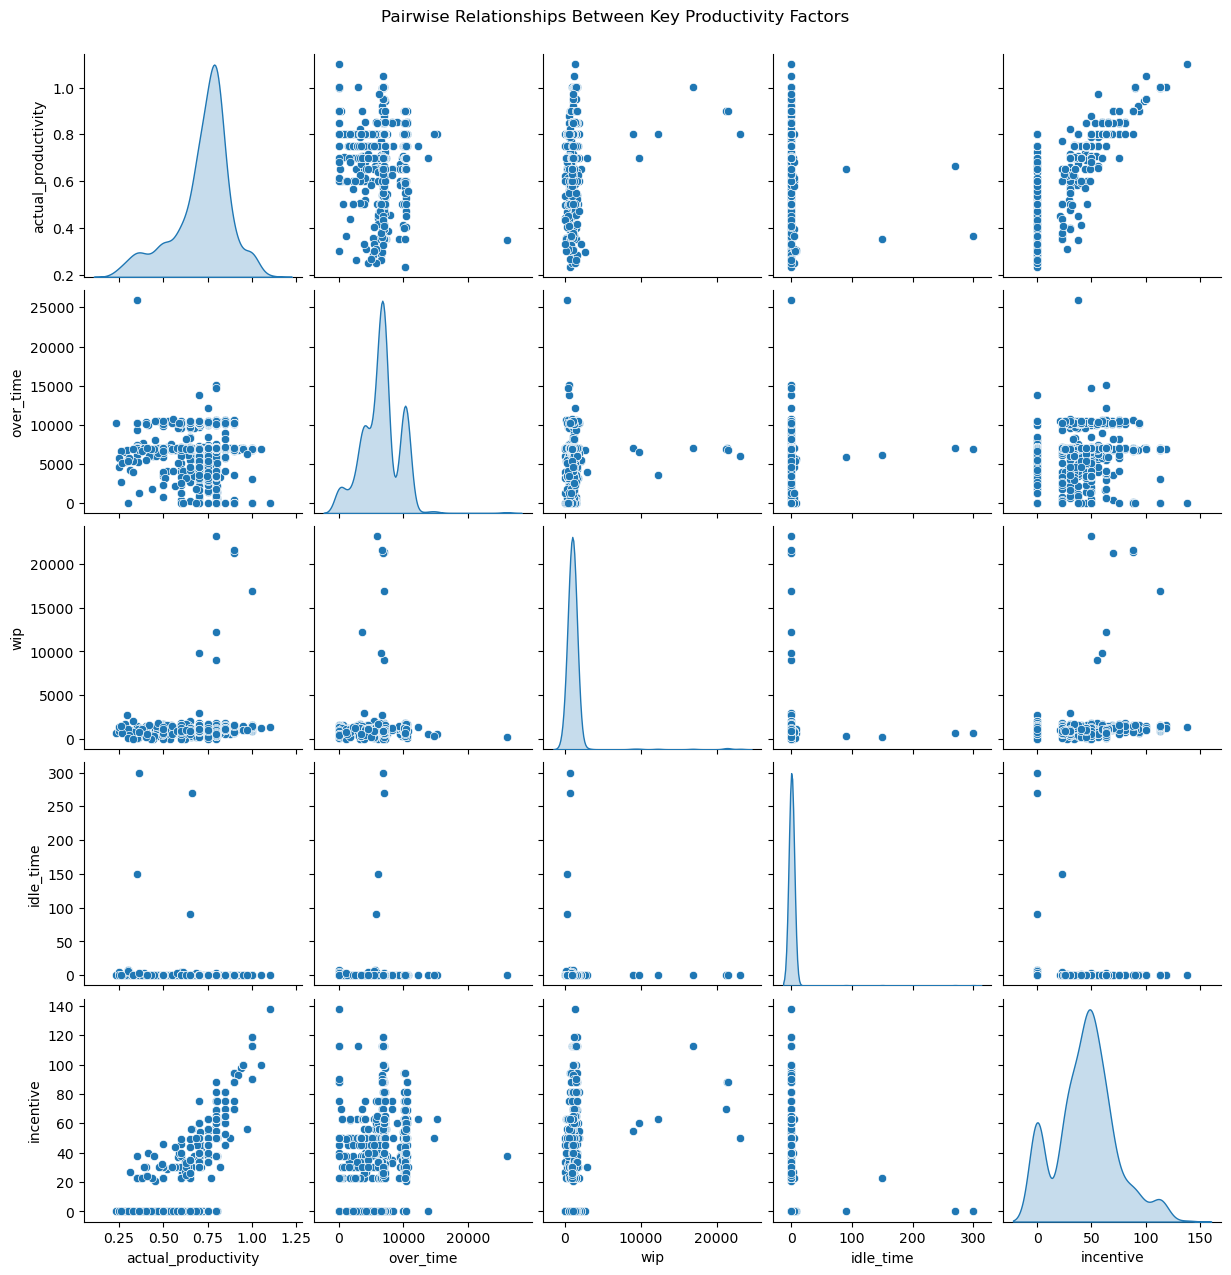

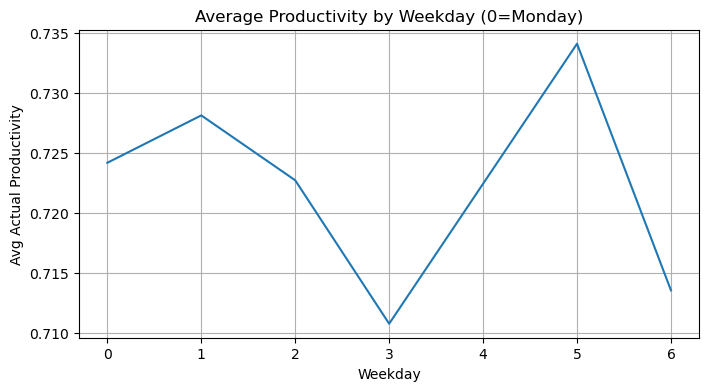

In [10]:
# Visualize top correlations with actual productivity
plt.figure(figsize=(12, 6))
corr_matrix = df.corr(numeric_only=True)
top_corr = corr_matrix['actual_productivity'].drop('actual_productivity').abs().sort_values(ascending=False)
top_features = top_corr.head(10).index.tolist() + ['actual_productivity']
sns.heatmap(df[top_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Top Correlated Features After Cleaning")
plt.tight_layout()
plt.show()

# Distribution plots
sns.histplot(df['actual_productivity'], bins=30, kde=True)
plt.title("Distribution of Actual Productivity")
plt.show()

sns.histplot(df['incentive'], bins=30, kde=True)
plt.title("Distribution of Incentive")
plt.show()

# Boxplot by Inefficiency
plt.figure(figsize=(10, 6))
sns.boxplot(x='inefficient', y='actual_productivity', data=df)
plt.title("Actual Productivity by Underperformance Status")
plt.xticks([0, 1], ['Efficient', 'Inefficient'])
plt.show()

# Pairplot of key numerical variables
key_vars = ['actual_productivity', 'over_time', 'wip', 'idle_time', 'incentive']
sns.pairplot(df[key_vars], diag_kind='kde')
plt.suptitle("Pairwise Relationships Between Key Productivity Factors", y=1.02)
plt.show()

# Lineplot of productivity trend by weekday
df_grouped = df.groupby('weekday')['actual_productivity'].mean()
plt.figure(figsize=(8, 4))
sns.lineplot(x=df_grouped.index, y=df_grouped.values)
plt.title("Average Productivity by Weekday (0=Monday)")
plt.xlabel("Weekday")
plt.ylabel("Avg Actual Productivity")
plt.grid(True)
plt.show()

### Step 5: Regression Model

In [12]:
# Set up regression features and target
X = df.drop(columns='actual_productivity')[top_features[:-1]]
y = df['actual_productivity']
# Define models for regression
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'SVR': SVR(),
    'GBR': GradientBoostingRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'Voting': VotingRegressor([
        ('ridge', Ridge()),
        ('svr', SVR()),
        ('gbr', GradientBoostingRegressor()),
        ('rf', RandomForestRegressor()),
        ('xgb', XGBRegressor())
    ])
}
# Evaluate models with cross-validation
results = {}
for name, model in models.items():
    # Cross-validated R²
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    r2 = scores.mean()
    # Cross-validated predictions for RMSE and MAE
    preds = cross_val_predict(model, X, y, cv=5)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    print(f"{name} Regressor:")
    print(f"  R² Mean CV Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}\n")
    results[name] = {'R²': round(r2, 4), 'RMSE': round(rmse, 4), 'MAE': round(mae, 4)}
# Tabulate model comparison
results_df = pd.DataFrame(results).T
print("Model Comparison:\n", results_df)

Linear Regressor:
  R² Mean CV Score: -0.1663
  RMSE: 0.2032
  MAE : 0.0604

Ridge Regressor:
  R² Mean CV Score: 0.2037
  RMSE: 0.1643
  MAE : 0.0579

SVR Regressor:
  R² Mean CV Score: 0.3699
  RMSE: 0.1181
  MAE : 0.0899

GBR Regressor:
  R² Mean CV Score: 0.8138
  RMSE: 0.0650
  MAE : 0.0385

Random Forest Regressor:
  R² Mean CV Score: 0.8025
  RMSE: 0.0684
  MAE : 0.0368

XGBoost Regressor:
  R² Mean CV Score: 0.8019
  RMSE: 0.0668
  MAE : 0.0376

Voting Regressor:
  R² Mean CV Score: 0.7988
  RMSE: 0.0700
  MAE : 0.0411

Model Comparison:
                    R²    RMSE     MAE
Linear        -0.1663  0.2032  0.0604
Ridge          0.2037  0.1643  0.0579
SVR            0.3699  0.1181  0.0899
GBR            0.8138  0.0650  0.0385
Random Forest  0.8025  0.0684  0.0368
XGBoost        0.8019  0.0668  0.0376
Voting         0.7988  0.0700  0.0411


### Step 6: Hyperparameter Tuning

In [14]:
# Hyperparameter tuning with randomized search for GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
# Define the model
gbr = GradientBoostingRegressor(random_state=42)
#  hyperparameter space
param_dist_gbr = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': stats.uniform(0.3, 0.7)
}
# Set up randomized search with 50 iterations
random_search_gbr = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist_gbr,
    n_iter=50,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
# Run the search
random_search_gbr.fit(X, y)
# Output results
print("Best GradientBoosting Parameters:")
print(random_search_gbr.best_params_)
print("Best R2 Score:", round(random_search_gbr.best_score_, 4))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GradientBoosting Parameters:
{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.9100224131314023, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}
Best R2 Score: 0.8251


### Step 7: Gradient Boosting Regressor with SHAP and LIME

Gradient Boosting RMSE: 0.05267583495767391


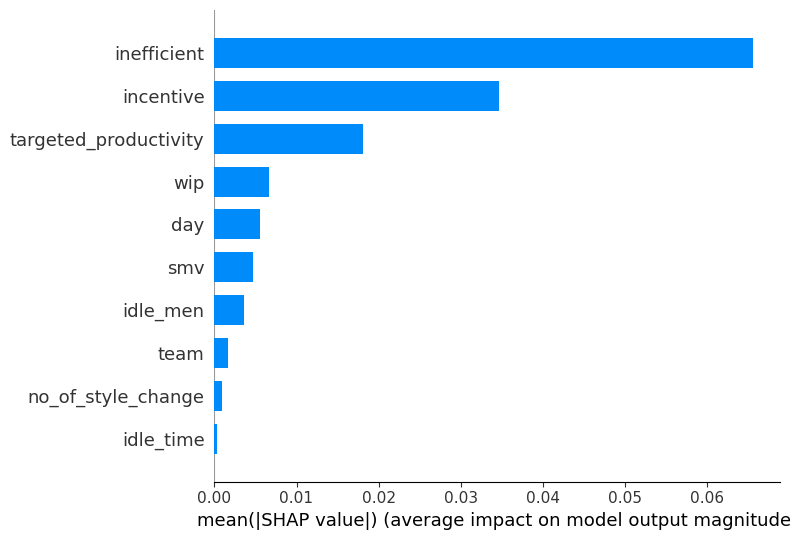

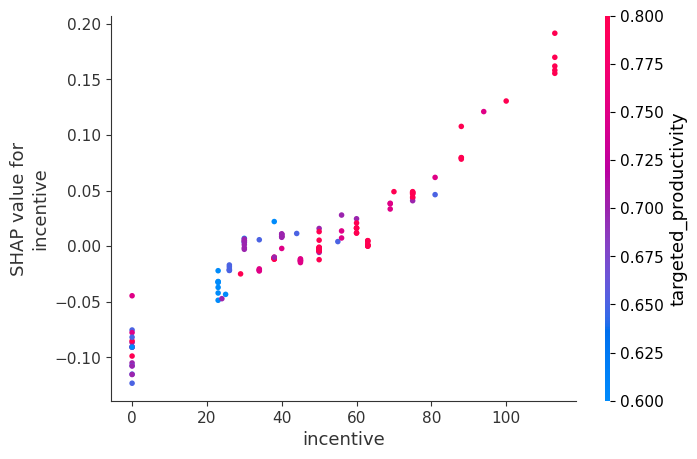

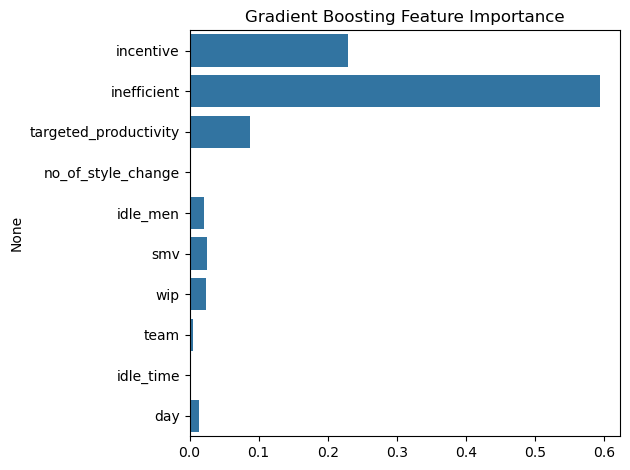

In [16]:
# Explainability with LIME and SHAP
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
# Gradient Boosting Regressor with SHAP and LIME
# Use top features (excluding target)
X_gbr = df.drop(columns='actual_productivity')[top_features[:-1]]
y_gbr = df['actual_productivity']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_gbr, y_gbr, test_size=0.2, random_state=42)
# Ensure numeric types for SHAP
X_train = X_train.astype(float)
X_test = X_test.astype(float)
# Train GBR model
gbr_model = GradientBoostingRegressor().fit(X_train, y_train)
gbr_preds = gbr_model.predict(X_test)
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, gbr_preds)))
# LIME instance explanation
explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='regression'
)
i = 5  # any index
exp = explainer_lime.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=lambda x: gbr_model.predict(pd.DataFrame(x, columns=X_test.columns))
)
exp.show_in_notebook(show_table=True)
# SHAP summary and dependence plots
explainer_shap = shap.Explainer(gbr_model, X_train)
shap_values = explainer_shap(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.dependence_plot("incentive", shap_values.values, X_test)
# Feature importance from trained GBR model
importances = gbr_model.feature_importances_
sns.barplot(x=importances, y=X_train.columns)
plt.title("Gradient Boosting Feature Importance")
plt.tight_layout()
plt.show()

### Step 8: Logistic Regression (Classification)

Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.94      0.82        83
        True       0.84      0.46      0.60        56

    accuracy                           0.75       139
   macro avg       0.78      0.70      0.71       139
weighted avg       0.77      0.75      0.73       139



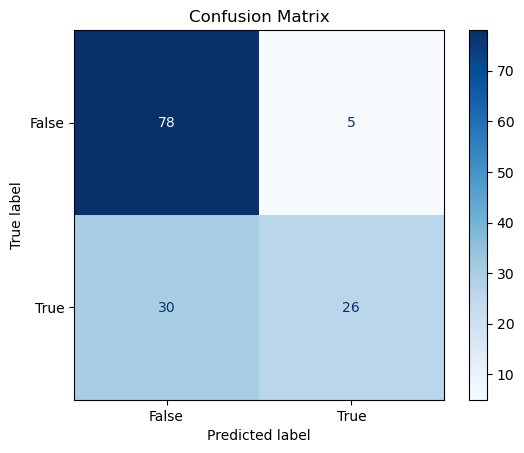

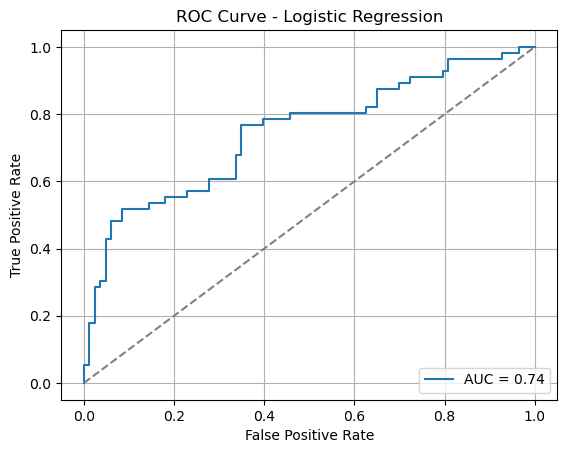

In [18]:
# Classification using logistic regression
X_cls = df[['wip', 'over_time', 'idle_time', 'no_of_style_change']]
y_cls = df['inefficient']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
# Train logistic regression
clf = LogisticRegression(max_iter=200, class_weight='balanced').fit(X_train, y_train)
# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of the positive class
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Step 9: PCA Visualization

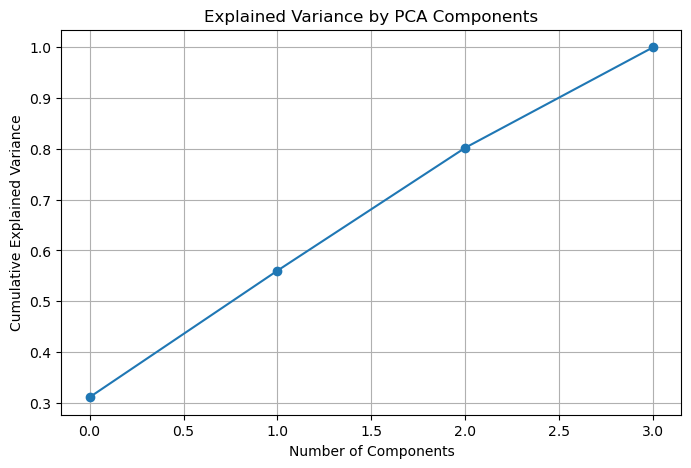

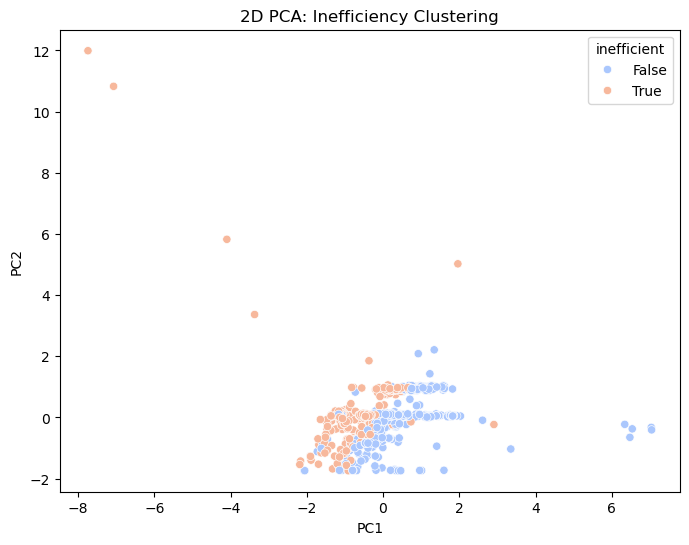

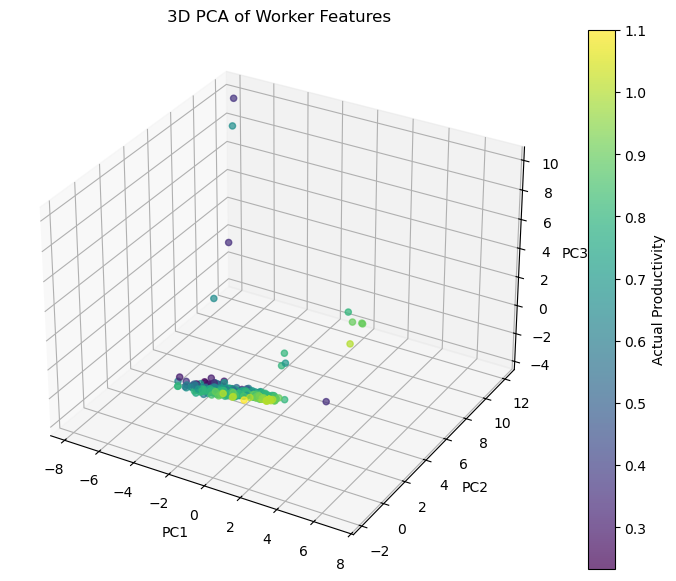

In [20]:
# PCA for visualizing multivariate structure
features_pca = ['wip', 'over_time', 'incentive', 'idle_time']
X_pca = StandardScaler().fit_transform(df[features_pca])
pca = PCA().fit(X_pca)
# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()
# 2D PCA Scatter (underperformance)
pca_2d = PCA(n_components=2).fit_transform(X_pca)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=df['inefficient'], palette='coolwarm')
plt.title("2D PCA: Inefficiency Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
# 3D PCA Visualization
pca_3d = PCA(n_components=3).fit_transform(X_pca)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], c=df['actual_productivity'], cmap='viridis', alpha=0.7)
ax.set_title("3D PCA of Worker Features")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
fig.colorbar(scatter, ax=ax, label="Actual Productivity")
plt.show()

### Step 10: Anomaly Detection using Isolation Forest

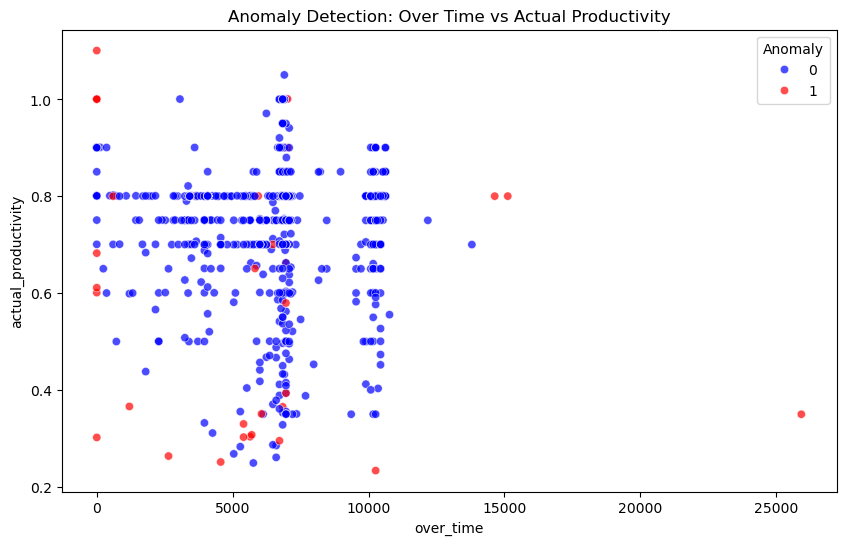

Total Anomalies Detected: 35


In [22]:
# Anomaly detection using Isolation Forest
from sklearn.ensemble import IsolationForest
anomaly_features = ['actual_productivity', 'over_time', 'idle_time', 'wip']
scaler = StandardScaler()
X_anomaly = scaler.fit_transform(df[anomaly_features])
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso_forest.fit_predict(X_anomaly)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})  # 1 = anomaly
# Visualize anomalies in scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='over_time', y='actual_productivity', hue='anomaly', data=df, palette={0: 'blue', 1: 'red'}, alpha=0.7)
plt.title("Anomaly Detection: Over Time vs Actual Productivity")
plt.legend(title='Anomaly')
plt.show()
# Count total anomalies
print("Total Anomalies Detected:", df['anomaly'].sum())